# Выделение признаков факторизацией матрицы

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.decomposition import NMF

# Создаём временные ряды и визуализируем их

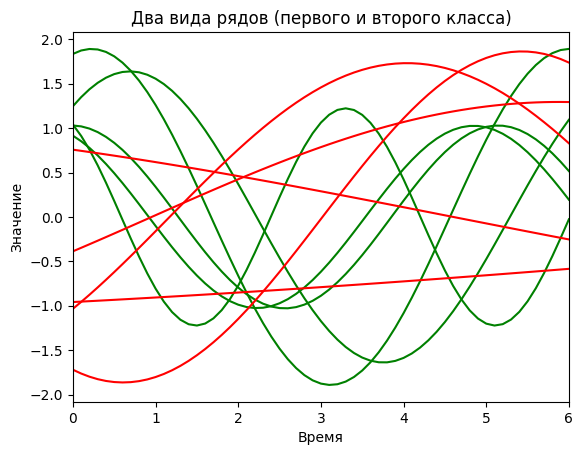

data.shape = (122000, 4)
data.id.nunique() = 2000


,t,y,class,id
0,0.0,3.245872,1,0
1,0.1,3.348260,1,0
2,0.2,3.436487,1,0


In [3]:
N = 1000 ## количество семплов каждого класса
Nvis = 5 ## сколько семплов будем визуализировать
timePoints = 61  ## количество элементов в каждом из рядов

df = pd.DataFrame()
data = pd.DataFrame()
t = np.linspace(0, 6, timePoints) 

random.seed(42)

## генерируем семплы первого класса
for i in range(N):
    A = 1 + random.random()        ## амплитуда
    w = 1 + random.random()        ## частота
    ph = np.pi * random.random()   ## фаза
    
    
    df['t']  = t                   ## ось времени
    df['y']  = A*np.sin(t*w + ph)  ## значения временного ряда
    df['class'] = 1                ## класс временного ряда 
    df['id'] = i                   ## номер временного ряда
    
    data = pd.concat([data, df], ignore_index=True)        ## добавляем семпл в общий дейтафрейм
    if i < Nvis:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='g') 
    
## генерируем семплы второго класса    
for i in range(N, 2*N):
    A = 1 + random.random()          ## амплитуда
    w = 0 + random.random()          ## частота
    ph = 2*np.pi * random.random()   ## фаза
    
    df['t']  = t                     ## ось времени
    df['y']  = A*np.sin(t*w + ph)    ## значения временного ряда
    df['class'] = 0                  ## класс временного ряда 
    df['id'] = i                     ## номер временного ряда
    
    data = pd.concat([data, df], ignore_index=True)          ## добавляем семпл в общий дейтафрейм
    if i < Nvis+N:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='r') 
    
## cдвигаем все значения вверх, чтобы все значения были положительными    
data['y'] = data.y + np.abs(data.y.min())
    
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title('Два вида рядов (первого и второго класса)')
plt.xlim([t[0], t[-1]])
plt.show()

print('data.shape =', data.shape)
print('data.id.nunique() =', data.id.nunique())
data.head(3)

# Выделение признаков

## Поворачиваем таблицу

In [4]:
dataPivoted = data.pivot(index='id', columns='t', values='y')
dataPivoted = dataPivoted.reset_index(drop=True)
dataPivoted['label'] = 0
dataPivoted['label'].iloc[N:] = 1
print('dataPivoted.shape =', dataPivoted.shape)
dataPivoted.head(3)

dataPivoted.shape = (2000, 62)


C:\Users\pavlu\AppData\Local\Temp\ipykernel_161560\513574978.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataPivoted['label'].iloc[N:] = 1


t,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,...,5.2,5.300000000000001,5.4,5.5,5.6000000000000005,5.7,5.800000000000001,5.9,6.0,label
0,3.245872,3.348260,3.436487,3.509626,3.566908,3.607734,3.631673,3.638476,3.628070,3.600564,...,1.853265,2.021114,2.188733,2.354361,2.516261,2.672732,2.822132,2.962893,3.093538,0
1,3.038675,2.911656,2.757190,2.579924,2.385190,2.178845,1.967094,1.756307,1.552825,1.362766,...,0.791555,0.843384,0.929975,1.048725,1.196061,1.367552,1.558040,1.761795,1.972689,0
2,3.834684,3.873698,3.890587,3.885151,3.857455,3.807827,3.736850,3.645365,3.534449,3.405412,...,3.210000,3.360586,3.495104,3.611965,3.709790,3.787425,3.843954,3.878708,3.891279,0


## Факторизация положительно определённой матрицы
Non-negative matrix factorization (NNMF)

In [5]:
# train, test = np.split(dataPivoted, [int(0.6*len(dataPivoted))])
train, test = train_test_split(dataPivoted, test_size=0.4, random_state=43) 
print('train.shape =', train.shape)
print('test.shape  =', test.shape)

## составляем список колонок со временем
timeColumns = train.drop('label', axis=1).columns

## факторизуем (раскладываем исходную матрицу на две)
## описываем требования к разложению (основное - раскладываем на три компоненты)
model = NMF(n_components=3, init='nndsvd', random_state=0, tol=0.001, max_iter=5000, solver='cd')
## находим функции разложения и извлекаем их
model.fit(train[timeColumns])
H = model.components_
## получаем коэффициенты разложения для тренировочного и тестового сетов
W_train = model.transform(train[timeColumns])
W_test  = model.transform(test[timeColumns])

print('H.shape =', H.shape)
print('W_train.shape =', W_train.shape) # выделенные признаки
print('W_test.shape =',  W_test.shape)  # выделенные признаки

train.shape = (1200, 62)
test.shape  = (800, 62)
H.shape = (3, 61)
W_train.shape = (1200, 3)
W_test.shape = (800, 3)


C:\An\Skillfactory\ML_M1\pythonProject\.venv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
C:\An\Skillfactory\ML_M1\pythonProject\.venv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
C:\An\Skillfactory\ML_M1\pythonProject\.venv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


## Визуализируем базисные функции (функции разложения)

In [12]:
train

t,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,...,5.2,5.300000000000001,5.4,5.5,5.6000000000000005,5.7,5.800000000000001,5.9,6.0,label
360,3.268797,3.345442,3.401795,3.437006,3.450543,3.442204,3.412114,3.360726,3.288815,3.197464,...,3.335531,3.394896,3.433222,3.449933,3.444776,3.417828,3.369497,3.300511,3.211909,0
520,2.414293,2.648868,2.866597,3.061835,3.229520,3.365304,3.465667,3.528007,3.550707,3.533179,...,3.081295,2.888792,2.673222,2.440175,2.195694,1.946116,1.697913,1.457521,1.231171,0
1653,2.943362,2.961594,2.978153,2.993010,3.006140,3.017519,3.027127,3.034949,3.040971,3.045181,...,1.845957,1.802831,1.760047,1.717678,1.675799,1.634481,1.593798,1.553819,1.514614,1
547,2.985702,3.063424,3.128356,3.179718,3.216891,3.239429,3.247062,3.239697,3.217424,3.180509,...,2.405840,2.532537,2.652824,2.765256,2.868480,2.961256,3.042470,3.111146,3.166457,0
1487,0.632693,0.503698,0.389555,0.291398,0.210200,0.146769,0.101735,0.075545,0.068458,0.080546,...,2.593120,2.407308,2.217443,2.025409,1.833115,1.642469,1.455366,1.273663,1.099166,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,3.426284,3.439235,3.418718,3.365210,3.279954,3.164932,3.022817,2.856912,2.671072,2.469617,...,2.077386,1.857869,1.641634,1.433708,1.238923,1.061806,0.906472,0.776533,0.675006,0
1841,3.465988,3.387319,3.303131,3.213760,3.119560,3.020905,2.918189,2.811819,2.702218,2.589822,...,0.711067,0.801346,0.896386,0.995810,1.099223,1.206214,1.316357,1.429214,1.544337,1
255,3.564869,3.387552,3.181569,2.951173,2.701122,2.436577,2.163002,1.886043,1.611419,1.344801,...,1.527755,1.264741,1.016891,0.789319,0.586727,0.413295,0.272605,0.167561,0.100332,0
1344,1.076405,1.075951,1.075498,1.075045,1.074593,1.074141,1.073690,1.073239,1.072789,1.072339,...,1.053453,1.053024,1.052596,1.052169,1.051742,1.051315,1.050889,1.050463,1.050038,1


Коэффициенты разложения для 54-элемента: [0.26931214 0.59420532 0.40156333]


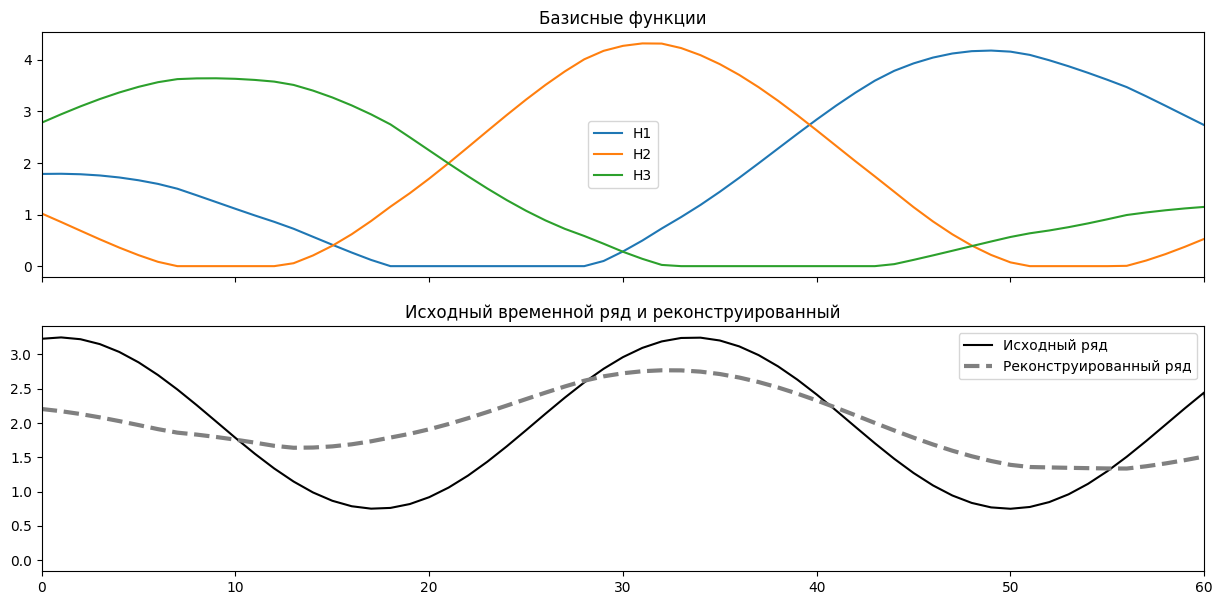

1.3417730980300475

In [11]:
ind = 54

f, ax = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
ax[0].plot(H[0,:])
ax[0].plot(H[1,:])
ax[0].plot(H[2,:])
# ax[0].plot(H[3,:])
# ax[0].plot(H[4,:])
# ax[0].legend(['H1', 'H2', 'H3', 'H4', 'H5'])
ax[0].legend(['H1', 'H2', 'H3'])
ax[0].set_title("Базисные функции")


print(f'Коэффициенты разложения для {ind}-элемента: {W_train[ind]}')
y = train.iloc[ind].values

ax[1].plot(y, 'k')

reconstr = W_train[ind].dot(H)
ax[1].plot(reconstr, color='gray', linestyle='--', lw=3)
ax[1].set_title('Исходный временной ряд и реконструированный')
ax[1].legend(['Исходный ряд', 'Реконструированный ряд'])
ax[1].set_xlim([0, len(y)-2])
plt.show()
reconstr[54]

# Разбивка на тренировочный и тестовый наборы

In [7]:
trainSet = pd.DataFrame()
testSet = pd.DataFrame()

## записываем фичи в дейтафрейм
for i in range(np.shape(W_train)[1]):
    trainSet['W_' + str(i)] = W_train[:,i]
    
for i in range(np.shape(W_test)[1]):
    testSet['W_' + str(i)] = W_test[:,i]
    
## добавляем классы исходного ряда    
trainSet['label'] = train.label.values
testSet['label']  = test.label.values        

print("trainSet.shape =", trainSet.shape)
print("testSet.shape =",  testSet.shape)
print()
print('Value counts train:\n', trainSet.label.value_counts())
print()
print('Value counts test:\n', testSet.label.value_counts())

trainSet.head(3)

trainSet.shape = (1200, 4)
testSet.shape = (800, 4)

Value counts train:
 label
1    602
0    598
Name: count, dtype: int64

Value counts test:
 label
0    402
1    398
Name: count, dtype: int64


,W_0,W_1,W_2,label
0,0.675387,0.000000,0.674082,0
1,0.690431,0.083129,0.621431,0
2,0.296551,0.588453,0.753541,1


# Машинное обучение

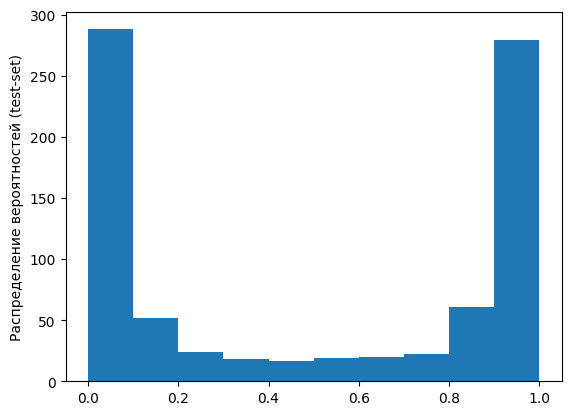

  features  importances
0      W_0     0.392670
1      W_1     0.316574
2      W_2     0.290756

   Pos  Neg
0  372   30
1   28  370

AUC = 0.981  Точность = 0.927



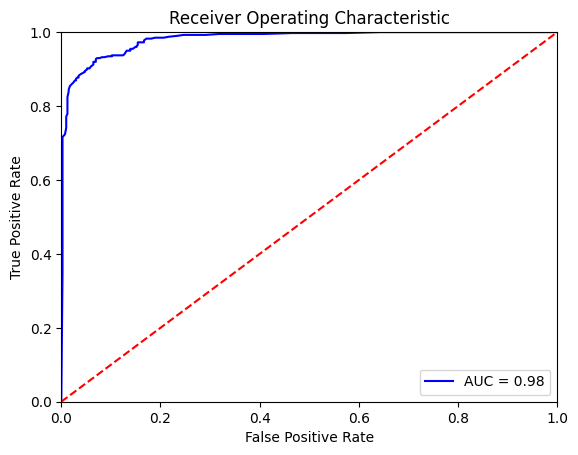

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from math import isnan

featureList = trainSet.drop('label', axis=1).columns

## параметры классификатора
params = {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'max_features' : 1.0, 'class_weight' : 'balanced',
         'random_state': 42}

## обучаем классификатор
clf = RandomForestClassifier(**params).fit(trainSet[featureList], trainSet['label'])

## делаем предсказание на тестовом наборе
y_pred = clf.predict(testSet[featureList])
y_pred_proba = clf.predict_proba(testSet[featureList])[:, 1] ## вероятности

## визуализируем вероятности для предсказаний
import matplotlib.pyplot as plt
plt.hist(y_pred_proba)
plt.ylabel('Распределение вероятностей (test-set)')
plt.show()

## создадим для удобства дейтафрейм с результатами
res = testSet
res['pred'] = y_pred 
res['pred_proba'] = y_pred_proba

## получаем из классификатора важность фич и отображаем их
ftmprt = pd.DataFrame()
ftmprt['features'] = featureList
ftmprt['importances'] = clf.feature_importances_
ftmprt = ftmprt.sort_values('importances', ascending=False)
print(ftmprt.head(20))
print()
proba = res.pred_proba

# confusion matrix
CM = confusion_matrix(res['label'], res['pred'])
CM_DF = pd.DataFrame(data=CM, columns = ['Pos', 'Neg'])
print(CM_DF)

## считаем матрицу ошибок
FPR, TPR, thresholds = roc_curve(res['label'], res['pred_proba'])
roc_auc = auc(FPR, TPR)
acc = res[res['pred'] == res['label']].shape[0] / res.shape[0]
print(f"\nAUC = {roc_auc:.3f}  Точность = {acc:.3f}\n")

# ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(FPR, TPR, 'b', label=f'AUC = {roc_auc:.2f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()